## Data preparation

For tuning the ML models and augmentation parameters, we need to split the train set into a train set and validation set. If we were to use temporal info later, we need to separate storms instead of images.



In [1]:
from separate_val_data import separate_val_files 

In [2]:
train_dir = 'data/train'
val_dir = 'data/val' 
# val dictionary should not exist, otherwise, it would raise error to avoid runnig it multiple times.
val_fr = 0.2

separate_val_files(train_dir, val_dir, val_fr)

ValueError: data/val already exist.

## Directory structure

```
project
|____data
|    |____train
|    |     |___abc_001.jpg
|    |     |___abc_002.jpg
|    |
|    |____val
|    |     |___acc_001.jpg
|    |     |___acc_002.jpg
|    |
|    |____training_set_features.csv
|    |____training_set_labels.csv
|____separate_val_data.py
|____image_batch_gen.py
|____Hurricane.ipynb
```

## Make batch

In [3]:
import os
from os.path import join
import pandas as pd
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [4]:
class ImgBatchGen(tf.keras.utils.Sequence):
    def __init__(self, img_dir, ground_truth_file, batch_size=32):
        self.bacth_size = batch_size
        files = os.listdir(img_dir)
        label_df = pd.read_csv(ground_truth_file, index_col=0, header=0)
        self.files = [(join(img_dir, f), label_df.loc[f[:7], 'wind_speed']) for f in files if f.endswith('.jpg')]
        random.shuffle(self.files)
        
    def __len__(self):
        return int(np.floor(len(self.files)/self.bacth_size))

    def __getitem__(self, index):
        images, labels = [], []

        for file, label in self.files[index*self.bacth_size:(index+1)*self.bacth_size]:
            img = cv2.imread(file, 0)
            if img is None:
                continue

            images.append(img)
            labels.append(label)

        x = np.array(images)[:, :, :, np.newaxis].astype(np.float32) / 255.0
        y = np.array(labels).astype(np.float32)

        return x, y
    

In [5]:
train_batchgen = ImgBatchGen('data/train', 'data/training_set_labels.csv', 32)
val_batchgen = ImgBatchGen('data/val', 'data/training_set_labels.csv', 32)

(32, 366, 366, 1) (32,)
61.0


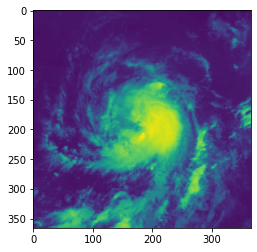

In [6]:
train_x, train_y = train_batchgen[0]
print(train_x.shape, train_y.shape)
plt.imshow(train_x[0])
print(train_y[0])

## Make Model

In [7]:
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

In [8]:
model = Sequential()
model.add(Conv2D(64, (7,7), padding='same', activation='relu', input_shape=(366, 366, 1)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

In [9]:
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 366, 366, 64)      3200      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 366, 366, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 183, 183, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 183, 183, 64)      36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 183, 183, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 91, 91, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        3

In [10]:
## Train

In [11]:
history = model.fit(val_batchgen, epochs = 100, verbose=1, validation_data=val_batchgen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 422 steps, validate for 422 steps
Epoch 1/100
422/422 [==============================] - 190s 450ms/step - loss: 632.1293 - mse: 632.1296 - mae: 17.5130 - mape: 39.5364 - val_loss: 324.0952 - val_mse: 324.0951 - val_mae: 13.6204 - val_mape: 32.9810
Epoch 2/100
422/422 [==============================] - 187s 443ms/step - loss: 358.1685 - mse: 358.1686 - mae: 13.9717 - mape: 31.8710 - val_loss: 346.1941 - val_mse: 346.1942 - val_mae: 14.1991 - val_mape: 35.9350
Epoch 3/100
422/422 [==============================] - 187s 444ms/step - loss: 317.9880 - mse: 317.9879 - mae: 13.0349 - mape: 29.6952 - val_loss: 263.2526 - val_mse: 263.2526 - val_mae: 11.6174 - val_mape: 26.0586
Epoch 4/100
422/422 [==============================] - 186s 442ms/step - loss: 269.9921 - mse: 269.9920 - mae: 11.9640 - mape: 27.4947 - val_loss: 235.4827 - val_mse: 235.4826 - val_mae: 10.8853 - val_mape: 22.9279
Epoch 5/100
422/422 [=========================

422/422 [==============================] - 185s 438ms/step - loss: 6.5858 - mse: 6.5858 - mae: 1.8711 - mape: 4.2221 - val_loss: 4.0113 - val_mse: 4.0113 - val_mae: 1.4766 - val_mape: 3.3843
Epoch 40/100
422/422 [==============================] - 185s 438ms/step - loss: 5.9655 - mse: 5.9655 - mae: 1.7915 - mape: 4.0433 - val_loss: 4.7831 - val_mse: 4.7831 - val_mae: 1.6171 - val_mape: 3.7964
Epoch 41/100
422/422 [==============================] - 185s 439ms/step - loss: 8.3045 - mse: 8.3045 - mae: 2.0977 - mape: 4.6866 - val_loss: 6.3122 - val_mse: 6.3122 - val_mae: 1.8635 - val_mape: 4.3592
Epoch 42/100
422/422 [==============================] - 185s 439ms/step - loss: 5.9930 - mse: 5.9930 - mae: 1.7817 - mape: 4.0107 - val_loss: 4.5103 - val_mse: 4.5103 - val_mae: 1.5757 - val_mape: 3.5806
Epoch 43/100
422/422 [==============================] - 185s 439ms/step - loss: 6.2772 - mse: 6.2772 - mae: 1.8238 - mape: 4.0825 - val_loss: 4.8904 - val_mse: 4.8904 - val_mae: 1.6079 - val_mape: 

422/422 [==============================] - 186s 440ms/step - loss: 3.3578 - mse: 3.3578 - mae: 1.3098 - mape: 2.8785 - val_loss: 1.6364 - val_mse: 1.6364 - val_mae: 0.9545 - val_mape: 2.1842
Epoch 80/100
422/422 [==============================] - 186s 440ms/step - loss: 2.2456 - mse: 2.2456 - mae: 1.0962 - mape: 2.4382 - val_loss: 2.4388 - val_mse: 2.4388 - val_mae: 1.1309 - val_mape: 2.5021
Epoch 81/100
422/422 [==============================] - 186s 441ms/step - loss: 3.0872 - mse: 3.0872 - mae: 1.2578 - mape: 2.7579 - val_loss: 3.2108 - val_mse: 3.2108 - val_mae: 1.3023 - val_mape: 2.8654
Epoch 82/100
422/422 [==============================] - 187s 443ms/step - loss: 3.0946 - mse: 3.0946 - mae: 1.2556 - mape: 2.7543 - val_loss: 3.2341 - val_mse: 3.2341 - val_mae: 1.2777 - val_mape: 2.6990
Epoch 83/100
422/422 [==============================] - 186s 441ms/step - loss: 3.0982 - mse: 3.0982 - mae: 1.2609 - mape: 2.7587 - val_loss: 3.8207 - val_mse: 3.8207 - val_mae: 1.4515 - val_mape: 

In [12]:
model.save('first_cut')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: first_cut\assets


In [48]:
ground_truth = []
pred = []
i = 0
for x_batch, y_batch in val_batchgen:
    pred.append(model.predict(x_batch).ravel())
    ground_truth.append(y_batch)
pred = np.hstack(pred)
ground_truth = np.hstack(ground_truth)

Text(0, 0.5, 'Prediction')

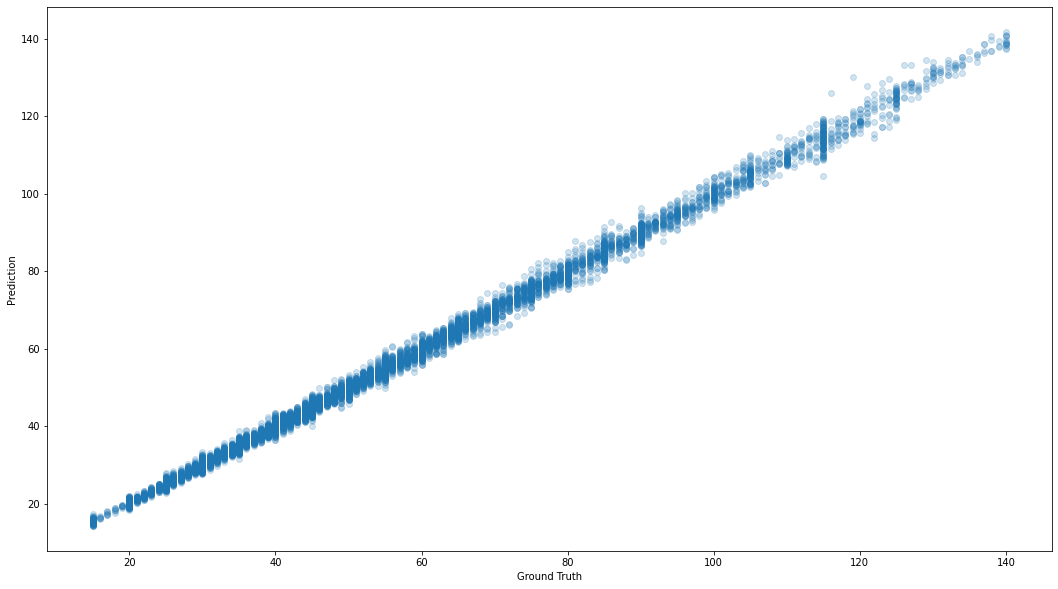

In [57]:
plt.figure(figsize=(18, 10))
plt.scatter(ground_truth, pred, alpha=0.2)
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')